Downloading Dependencies


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2, imghdr
import numpy as np

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download sujaykapadnis/emotion-recognition-dataset


Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset
License(s): CC-BY-NC-SA-4.0
100% 1.97G/1.98G [00:20<00:00, 85.6MB/s]
100% 1.98G/1.98G [00:20<00:00, 104MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emotion-recognition-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
data_dir = 'dataset'

Dataset consist of 6 different emotional pictures

In [5]:
for i in os.listdir(data_dir):
  print(i)

Angry
Happy
Ahegao
Neutral
Surprise
Sad


In [6]:
img = cv2.imread(os.path.join('dataset','Ahegao','cropped_emotions.16473~ahegao.png'))

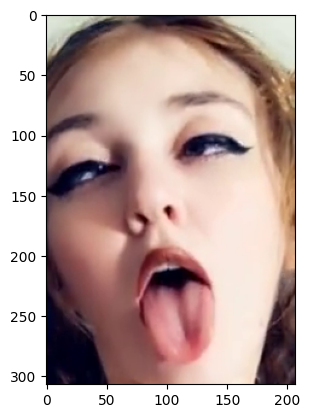

In [7]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [8]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 15453 files belonging to 6 classes.


#2. Preprocess Data


Scaling the data/image

In [9]:
#scaling data
data = data.map(lambda x,y: (x/255, y))

In [10]:
sc = data.as_numpy_iterator()
batch = sc.next()

In [11]:
batch[0].max()

1.0

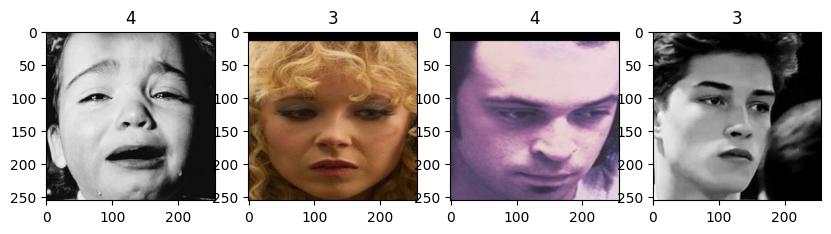

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for i, img in enumerate(batch[0][:4]):
  ax[i].imshow(img)
  ax[i].title.set_text(batch[1][i])
  #class 0 - Ahegao
  #class 1 - Angry
  #class 2 - Happy
  #class 3 - Neutral
  #class 4 - Sad
  #class 5 - Surprise

In [13]:
len(data)
#total number of batches

483

# 3. Deep model

In [14]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Transfer learning using VGG16 and applying fine-tuning method

In [17]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

using fine-tuning method of Transfer learning and allowed base model and fully connected layers to update its weights

In [18]:
conv_base.trainable=True
s =False
for layer in conv_base.layers:
  if layer.name=='block5_conv1':
    s=True
  if s:
    layer.trainable=True
  else:
    layer.trainable =False


Data Augmentation to prevent overfitting and ensuring Good model training

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.2)

# Load data with augmentation
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'
)

val_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# test_data = test_datagen.flow_from_directory(
#     data_dir,
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode='categorical'
# )

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


Model Training

In [20]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(train_data.num_classes, activation='softmax'))

fine-tuning hyperparameter

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

using callback funtion like early stopping:
Early Stopping : Stops training when the model stops improving to prevent overfitting and save computation time.

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


The training shows improving accuracy and decreasing loss initially, indicating good learning. However, from epoch 8, validation performance drops significantly (val_accuracy and val_loss worsen), suggesting overfitting. Spikes in val_loss (e.g., epochs 13–14) further confirm instability. Consider techniques like early stopping, learning rate adjustment, or regularization.

In [24]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Increased to allow early stopping to trigger
    callbacks=[early_stopping]
)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 267s 677ms/step - accuracy: 0.6177 - loss: 1.5816 - val_accuracy: 0.5036 - val_loss: 2.5441
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 263s 670ms/step - accuracy: 0.6786 - loss: 1.3693 - val_accuracy: 0.6221 - val_loss: 1.3988
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 321s 667ms/step - accuracy: 0.7122 - loss: 1.2396 - val_accuracy: 0.6483 - val_loss: 1.6061
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 265s 673ms/step - accuracy: 0.7508 - loss: 1.1214 - val_accuracy: 0.7076 - val_loss: 1.3480
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 263s 669ms/step - accuracy: 0.7698 - loss: 0.9865 - val_accuracy: 0.7092 - val_loss: 1.2655
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 261s 664ms/step - accuracy: 0.7877 - loss: 0.8773 - val_accuracy: 0.7458 - val_loss: 1.0349
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 261s 661ms/step - accuracy: 0.7984 - loss: 0.7964 - val_accuracy: 0.7843 - val_loss: 0.7741
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 269s 679ms/step - accuracy: 0.7867 -

The graph shows training accuracy (blue) steadily increasing, while validation accuracy (orange) fluctuates and drops sharply after epoch 12, confirming little bit overfitting

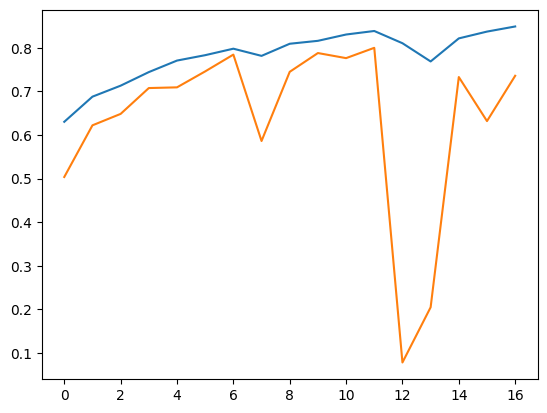

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

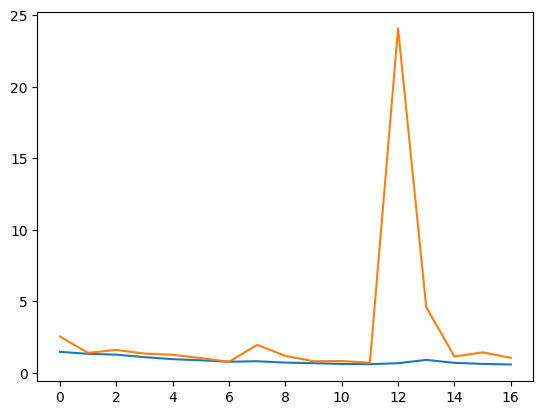

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#Model Evaluation


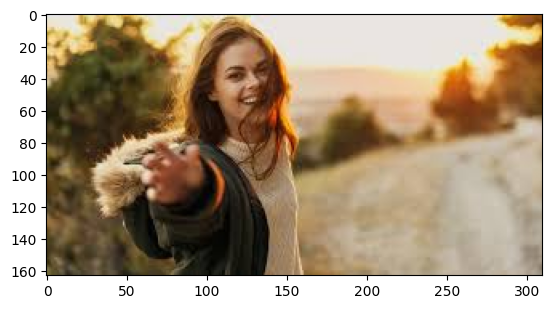

In [110]:
import cv2
img = cv2.imread('happy.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

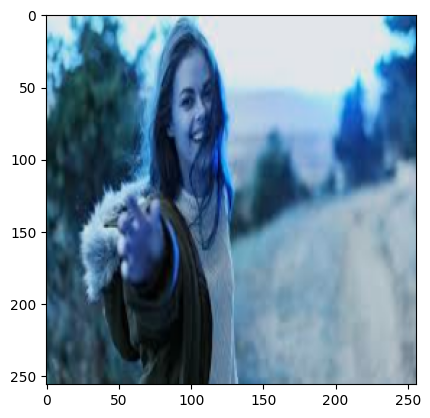

In [111]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [112]:
yhat = np.argmax(model.predict(np.expand_dims(resize/255,0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [113]:
if yhat ==0:
  print(f'Predicted class is Ahegao')
elif yhat == 1:
  print(f'Predicted class is Angry')
elif yhat == 2:
  print(f'Predicted class is Happy')
elif yhat == 3:
  print(f'Predicted class is Nuetral')
elif yhat == 4:
  print(f'Predicted class is Sad')
else:
  print(f'Predicted class is Surprise')


Predicted class is Sad


#Save Model

In [98]:
from tensorflow.keras.models import load_model

In [99]:
model.save(os.path.join('models','EmotionClassifier.h5'))

In [100]:
new_model = load_model(os.path.join('models','EmotionClassifier.h5'))

In [101]:
y_pred = np.argmax(new_model.predict(np.expand_dims(resize/255,0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


In [102]:
y_pred

4

In [103]:
if y_pred ==0:
  print(f'Predicted class is Ahegao')
elif y_pred == 1:
  print(f'Predicted class is Angry')
elif y_pred == 2:
  print(f'Predicted class is Happy')
elif y_pred == 3:
  print(f'Predicted class is Nuetral')
elif y_pred == 4:
  print(f'Predicted class is Sad')
else:
  print(f'Predicted class is Surprise')


Predicted class is Sad
